In [1]:
import tensorflow as tf
import sys
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
import pandas as pd
import numpy as np

# Define the path to your Excel file within the "Data" folder
file_path = "./15-12 Final Training data set.xlsx"


# Read the Excel file into a DataFrame
df = pd.read_excel(file_path)
df

,Sentences,Label
0,A t-test confirmed that no significant differe...,Correct
1,No significant difference in HBP scores betwee...,Correct
2,No significant difference was found in any oth...,Correct
3,it was therefore assumed that this minimal var...,Correct
4,no significant differences were observed in th...,Correct
...,...,...
295,"as compared with CHO, 12 while there was no di...",Incorrect
296,"As shown in Table 1, there were no differences...",Incorrect
297,"Also, there was no effect of time (p = 0.552) ...",Incorrect
298,NEFA concentrations dropped from the baseline ...,Incorrect


In [3]:
label_mapping = {'Incorrect': 0, 'Correct': 1}
df['Label'] = df['Label'].replace(label_mapping)
df

,Sentences,Label
0,A t-test confirmed that no significant differe...,1
1,No significant difference in HBP scores betwee...,1
2,No significant difference was found in any oth...,1
3,it was therefore assumed that this minimal var...,1
4,no significant differences were observed in th...,1
...,...,...
295,"as compared with CHO, 12 while there was no di...",0
296,"As shown in Table 1, there were no differences...",0
297,"Also, there was no effect of time (p = 0.552) ...",0
298,NEFA concentrations dropped from the baseline ...,0


In [4]:
print('Positive samples: %d of %d (%.2f%%)' % (df.Label.sum(), len(df.Label), (df.Label.sum() / len(df.Label) * 100.0)))

Positive samples: 150 of 300 (50.00%)


In [5]:
# Get the lists of sentences and their labels.
sentences = df.Sentences.values
labels = df.Label.values

In [6]:
print(labels.dtype)

int64


In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=True)
model = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

In [8]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  A t-test confirmed that no significant difference existed between the two groups ( t(30) = 0.74, P=0 .
Tokenized:  ['a', 't', '-', 'test', 'confirmed', 'that', 'no', 'significant', 'difference', 'existed', 'between', 'the', 'two', 'groups', '(', 't', '(', '30', ')', '=', '0', '.', '74', ',', 'p', '=', '0', '.']
Token IDs:  [106, 105, 579, 856, 3804, 198, 425, 684, 1673, 16158, 467, 111, 502, 1302, 145, 105, 145, 1339, 546, 275, 244, 205, 7667, 422, 118, 275, 244, 205]


In [9]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  A t-test confirmed that no significant difference existed between the two groups ( t(30) = 0.74, P=0 .
Token IDs: [102, 106, 105, 579, 856, 3804, 198, 425, 684, 1673, 16158, 467, 111, 502, 1302, 145, 105, 145, 1339, 546, 275, 244, 205, 7667, 422, 118, 275, 244, 205, 103]


In [10]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  316


In [11]:
average_length = sum(len(sen) for sen in input_ids) / len(input_ids)
print('Average sentence length:',average_length)

Average sentence length: 48.19


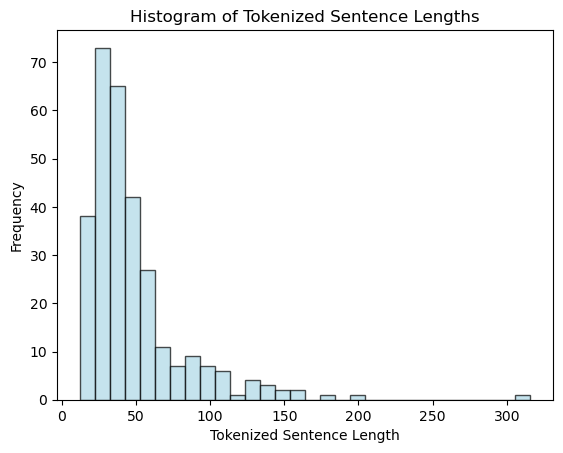

In [12]:
import matplotlib.pyplot as plt

# Calculate the lengths of tokenized sentences
sentence_lengths = [len(sen) for sen in input_ids]

# Create a histogram
plt.hist(sentence_lengths, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
plt.xlabel('Tokenized Sentence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Tokenized Sentence Lengths')
plt.show()

In [13]:
cutoff_length = 150

# Count the number of sentences below the cutoff
sentences_below_cutoff = sum(1 for length in sentence_lengths if length < cutoff_length)

print(f'Number of sentences below {cutoff_length} tokens: {sentences_below_cutoff}')

Number of sentences below 150 tokens: 295


In [14]:
cutoff_length = 150

# Find the sentences above the cutoff
long_sentences = [sentences[i] for i, length in enumerate(sentence_lengths) if length >= cutoff_length]

# Print the long sentences with a line space between each
for idx, long_sentence in enumerate(long_sentences):
    print(f'Sentence {idx + 1} (Length: {len(long_sentence)}):\n{long_sentence}\n')

Sentence 1 (Length: 792):
Selfreport data and preliminary analyses  Oneway ANOVAs revealed no significant differences between  groups in their ages (M 18–22 years, SD 1.23 –2.85), F (2, 46)  0.12, p F.05; weight (M 63.2 –68.4 kg, SD 9.60 –14.65), F (2, 46)  0.39, p F.05; height (M 168.30 cm–171.07 cm, SD 9.07 –9.84), F (2,  46) 0.68, p F.05; training hours/day (M 2.66 –2.90 h, SD  0.57 –2.00), F (2, 46) 0.65, p F.05; training days/week (M  3.10 –3.42, SD 0.71 –1.40), F (2, 46) 0.38, p F.05; year of experience  (M 5.07 –5.86, SD 2.46 –4.05), F (2, 46) 0.30, p F.05; or MIQR  scores (M 15.9 –18.34, SD 2.08 –3.25), F (2, 46) 2.65, p F.05;  indicating no betweengroup differences in terms of age, weight, height,  training hours/day, training days/week, year of experience, and imagery ability.

Sentence 2 (Length: 396):
There was a small albeit significant increase in IL6,  8 and 10 concentrations  pre to postmatch in both PLB (IL6: 0.83±0.92 Vs 2.91±1.40, IL8: 2.16±1.22 

In [15]:
# We will use some utility function from tensorflow(Tensorflow was my first crush)
from keras.preprocessing.sequence import pad_sequences


MAX_LEN = 150

#Padding the input to the max length that is 150
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


In [16]:
# Creating the attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [17]:
# # We will call the train_test_split() function from sklearn
# from sklearn.model_selection import train_test_split

# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
#                                                             random_state=2018, test_size=0.1)
# # Performing same steps on the attention masks
# train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
#                                              random_state=2018, test_size=0.1)

from sklearn.model_selection import train_test_split

# Split into training and temporary (remaining) data
train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(input_ids, labels, 
                                                                        random_state=2018, test_size=0.2)

# Further split the remaining data into validation and test sets
validation_inputs, test_inputs, validation_labels, test_labels = train_test_split(temp_inputs, temp_labels,
                                                                                  random_state=2018, test_size=0.5)

# Repeat the same steps for attention masks
train_masks, temp_masks, _, _ = train_test_split(attention_masks, labels,
                                                random_state=2018, test_size=0.2)
validation_masks, test_masks, _, _ = train_test_split(temp_masks, temp_labels,
                                                      random_state=2018, test_size=0.5)

In [18]:
import numpy as np

# Count the labels in each set
train_label_counts = np.bincount(train_labels)
validation_label_counts = np.bincount(validation_labels)
test_label_counts = np.bincount(test_labels)

# Print the counts
print("Train label counts:", train_label_counts)
print("Validation label counts:", validation_label_counts)
print("Test label counts:", test_label_counts)


Train label counts: [128 112]
Validation label counts: [10 20]
Test label counts: [12 18]


In [19]:
#Converting the input data to the tensor , which can be feeded to the model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Creating the DataLoader which will help us to load data into the CPU
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4)


# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import BertForSequenceClassification, BertTokenizer

# Specify the SciBERT model identifier
scibert_model_identifier = "allenai/scibert_scivocab_uncased"

# Load the SciBERT tokenizer
tokenizer = BertTokenizer.from_pretrained(scibert_model_identifier)

# Load the SciBERT model
model = BertForSequenceClassification.from_pretrained(
    scibert_model_identifier,
    num_labels=2,  # Adjust the number of labels based on your task
    output_attentions=True,
    output_hidden_states=False,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# AdamW is an optimizer which is a Adam Optimzier with weight-decay-fix
from transformers.optimization import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 3e-5,  
                  eps = 1e-8,
                )

C:\Users\tessa\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Set the number of warm-up steps to 10% of the total steps
warmup_steps = int(0.1 * total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)
scheduler

In [24]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
#Creating the helper function to have a watch on elapsed time

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
import random
import numpy as np
import torch
from transformers import BertForSequenceClassification, AdamW, BertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU (if available)
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs.logits

        # Move


        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.70
  Training epoch took: 0:02:15

Running Validation...
  Accuracy: 0.60
  Validation took: 0:00:06

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.57
  Training epoch took: 0:02:12

Running Validation...
  Accuracy: 0.67
  Validation took: 0:00:06

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.41
  Training epoch took: 0:02:12

Running Validation...
  Accuracy: 0.73
  Validation took: 0:00:06

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.25
  Training epoch took: 0:02:15

Running Validation...
  Accuracy: 0.73
  Validation took: 0:00:06

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.18
  Training epoch took: 0:02:09

Running Validation...
  Accuracy: 0.87
  Validation took: 0:00:06

Training complete!


In [27]:
print(loss_values) #Having a view of stored loss values in the list

[0.7038919553160667, 0.5734166726469994, 0.4106128290295601, 0.24524438008666039, 0.17698074504733086]


In [28]:
#Loading the test data and applying the same preprocessing techniques which we performed on the train data

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.Sentences.values
labels = df.Label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 300



In [29]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_inputs.shape[0]))

# Convert to tensors.
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


Number of test sentences: 30



In [30]:
# Report the number of sentences.
print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))


# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Create the DataLoader.
test_data = TensorDataset(torch.tensor(test_inputs), torch.tensor(test_masks), torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Predict 
for batch in test_dataloader:
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits.detach().numpy()

    # Move labels to CPU
    label_ids = b_labels.numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)


Predicting labels for 30 test sentences...


Accuracy: 0.9000
Precision: 0.9200
Recall: 0.9000
F1 Score: 0.9010


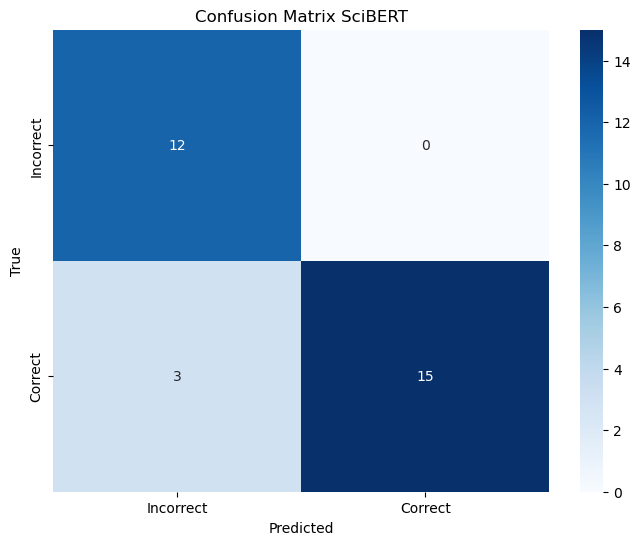

In [38]:
# Flatten the nested lists of predictions and true labels
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to predicted labels
predicted_labels = np.argmax(flat_predictions, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(flat_true_labels, predicted_labels)
precision = precision_score(flat_true_labels, predicted_labels, average='weighted', zero_division=1)  # Set zero_division to 1
recall = recall_score(flat_true_labels, predicted_labels, average='weighted')
f1 = f1_score(flat_true_labels, predicted_labels, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Incorrect', 'Correct'], yticklabels=['Incorrect', 'Correct'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix SciBERT')
plt.show()


In [32]:
import pandas as pd
import numpy as np

# Flatten the nested lists of predictions and true labels
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to predicted labels
predicted_labels = np.argmax(flat_predictions, axis=1)

# Ensure that the lengths match
min_length = min(len(flat_true_labels), len(predicted_labels), len(sentences))
flat_true_labels = flat_true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]
sentences = sentences[:min_length]

# Create a DataFrame for misclassified sentences
misclassified_df = pd.DataFrame({
    'True Label': flat_true_labels,
    'Predicted Label': predicted_labels,
    'Sentence': sentences
})

# Filter the DataFrame to include only misclassified sentences
misclassified_df = misclassified_df[misclassified_df['True Label'] != misclassified_df['Predicted Label']]

# Set pandas options for better display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Assuming you have the misclassified DataFrame named misclassified_df

# Change labels for better readability
misclassified_df['True Label'] = np.where(misclassified_df['True Label'] == 1, 'Correct', 'Incorrect')
misclassified_df['Predicted Label'] = np.where(misclassified_df['Predicted Label'] == 1, 'Correct', 'Incorrect')

# Save the misclassified DataFrame to an Excel file
misclassified_df.to_excel("misclassified_sentences2.xlsx", index=False)

# Now, read the Excel file into a new DataFrame
misclassified_df_from_excel = pd.read_excel("misclassified_sentences2.xlsx")

misclassified_df_from_excel


,True Label,Predicted Label,Sentence
0,Correct,Incorrect,"There were no significant differences between the trials for the TTF at 110% V ̇O2max (F 5156.1635.5, S5223.7 642.9, W 5161.1621.4 seconds, p50.18; ES, 20.54; 95% CI, 139.4 –221.2)."
1,Correct,Incorrect,"Given the working-set MCVs in both conditions did not differ greatly, it is possible the current subjects were not strong enough to exhibit a PAP response during the down sets or a longer rest interval was needed after the working sets to dissipate fatigue before performing the down set."
2,Correct,Incorrect,"This hypothesis, however, was not supported when investigating ingame performance."


In [33]:
import os
# Specify the directory where you want to save the model
output_dir = './trained_model2/'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model to directory
model.save_pretrained(output_dir)

# Save tokenizer to directory
tokenizer.save_pretrained(output_dir)

# Save configuration to directory
model.config.save_pretrained(output_dir)

In [34]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the saved model and tokenizer
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

In [35]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the saved model and tokenizer
output_dir = './trained_model2/'
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Input sentences for classification
sentences2 = [
  "Given the working-set MCVs in both conditions did not differ greatly, it is possible the current subjects were not strong enough to exhibit a PAP response during the down sets or a longer rest interval was needed after the working sets to dissipate fatigue before performing the down set.",
  "The results for the plankhold followed a similar pattern but were not statistically significant.",
  "Rows that share the same subscript letter, do not differ significantly.",
  "Aerobic fitness groups did not differ significantly by  ethnicity, race, sex, estimated IQ, education, pastyear cannabis use,  pastyear alcohol use, recent nicotine exposure (cotinine level), or amount of sedentary behavior (see Table 1).",
  "Repeatedmeasures ANOVA results indicated a significant effect between each 5 s interval (p < 0.001), but no differences  were observed between trials ( p > 0.05).",
  "LT assessedby VO 2(Figure 2 (E)) did also not differ significantly between BC supplementation and placebo ( p>.",
  "Although we did note a trend toward increased D’ and time to exhaustion in a cohort of our subjects, but these were weak trends that did not reach statistical significance and the effect sizes were small to medium, but variable.",
  "In this respect, recent reviews have suggested that the use of compression garments after running  has little or no effect on muscle damage and inflammatory markers (Brown et al., 2017; Engel et  al., 2016).",
  "Similarly, there was a decrease in PLB (2.16±0.34  m.s1) and MC (2.17±0.33 m.s1) drop jump performance from 24h prematch to 48h postmatch  (PLB: 2.05±0.40 m.s1 and MC: 2.06±0.41 m.s1) although this was not statistically significant  (P=0.228 and P =0.893, respectively).",
  "Nonetheless, they were significantly higher in DELAY  (+ 3.6 ± 3.5 mU ∙ L1; p = 0.003) and CHO (+ 4.7 ± 3.0; mU ∙ L1 p < 0.001) as compared with PLA , whereas there was no difference between DELAY and CHO (p > 0.999) at 60min.",
  "5.2 ± 0.6 mmol ∙ L1) as compared to PLA (4.2 ± 0.6  and 3.3 ± 0.6 mmol ∙  L1) at 60min and post TT time points (p < 0.05) with no difference between CHO and DELAY (p >  0.999) conditions.",
  "AUC for glucose was significantly higher in CHO as compared with PLA (p =  0.006), whereas there was no difference between CHO and DELAY (p = 0.189) or PLA and  DELAY (p = 0.228 ).",
  "AUC for lactate was significantly higher in CHO as compared with PLA (p = 0.029 ) and  DELAY (p = 0.019), whereas there was no difference between PLA and DELAY (p = 0.974).",
  "However, in their study, the preservation of muscular force could  not be attributed to changes in the central factor because voluntary activation (VA) d oes not differ  between the maltodextrin and placebo mouth rinse groups.",
  "There were no differences in T lim between conditions (BR = 22.8 ± 8.1 min;  Placebo = 20.7 ± 7.9 min) ( P = 0.184), despite increases in plasma",
  "Dietary NO 3 supplementation had no effect on exercise tolerance or thermoregulation in hot, dry  conditions, despite reductions in resting MAP and increases in plasma",
  "There were no differences ( t(10)= 1.4, P = 0.184) in T lim between the BR and PLA  conditions, despite seven out of the eleven participants extending their performance  after BR supplementation (BR = 22.8 ± 8 .1min; Placebo = 20.7 ± 7.9min).",
  "There were no differences between  PLA and BR for H prod (t(10) = 0.103, P = 0.920), H dry (t(10) = 1.913, P = 0.085), E req (t(10)  = 0.789, P = 0.448), heat storage ( t(10) = 0.941, P = 0.369), E max (t(10) = 1.919, P =  0.084) or W ( t(10) = 0.101, P = 0.337)"
]

# Tokenize input sentences
tokenized_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Ensure the model is in evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    # Forward pass
    outputs = model(**tokenized_input)

# Get the predicted probabilities
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get the predicted class (0 or 1 in binary classification)
predicted_class = torch.argmax(probs, dim=1).tolist()

# Display results
for sentence, label in zip(sentences, predicted_class):
    print(f"Sentence: {sentence}")
    print(f"Predicted Label: {label}")
    print()
    
    
#1 is correct 0 is incorrect

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentence: Given the working-set MCVs in both conditions did not differ greatly, it is possible the current subjects were not strong enough to exhibit a PAP response during the down sets or a longer rest interval was needed after the working sets to dissipate fatigue before performing the down set.
Predicted Label: 1

Sentence: The results for the plankhold followed a similar pattern but were not statistically significant.
Predicted Label: 0

Sentence: Rows that share the same subscript letter, do not differ significantly.
Predicted Label: 1

Sentence: Aerobic fitness groups did not differ significantly by  ethnicity, race, sex, estimated IQ, education, pastyear cannabis use,  pastyear alcohol use, recent nicotine exposure (cotinine level), or amount of sedentary behavior (see Table 1).
Predicted Label: 0

Sentence: Repeatedmeasures ANOVA results indicated a significant effect between each 5 s interval (p < 0.001), but no differences  were observed between trials ( p > 0.05).
Predicted 